# HistGradientBoostingRegressor

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
%matplotlib inline



In [2]:
df = pd.read_csv("compteur-one-hot-encoded.csv", index_col=0)
display(df)

,Comptage horaire,Jour,Mois,Année,Heure,Jour_semaine,Jour férié,Vacances scolaires,Nom du compteur_10 avenue de la Grande Armée SE-NO,Nom du compteur_10 boulevard Auguste Blanqui NE-SO,...,Nom du compteur_Totem 64 Rue de Rivoli E-O,Nom du compteur_Totem 64 Rue de Rivoli O-E,Nom du compteur_Totem 73 boulevard de Sébastopol N-S,Nom du compteur_Totem 73 boulevard de Sébastopol S-N,Nom du compteur_Totem 85 quai d'Austerlitz NO-SE,Nom du compteur_Totem 85 quai d'Austerlitz SE-NO,Nom du compteur_Totem Cours la Reine E-O,Nom du compteur_Totem Cours la Reine O-E,Nom du compteur_Voie Georges Pompidou NE-SO,Nom du compteur_Voie Georges Pompidou SO-NE
12886,3166,14,6,2023,14,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
685401,3070,5,1,2025,15,7,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
667057,3010,20,6,2023,23,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12622,2925,2,6,2023,16,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12680,2887,16,6,2023,5,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403638,0,24,9,2023,11,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
706585,0,24,9,2023,12,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187772,0,24,9,2023,12,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404653,0,24,9,2023,12,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# On applique un logarithme sur la valeur cible pour éviter la dispersion des données
# et faciliter l'apprentissage du modèle

df["Comptage horaire"] = np.log1p(df["Comptage horaire"])

In [6]:
# TODO séparer dataset d'entrainement et dataset de test
y = df["Comptage horaire"]
X = df.drop(columns=["Comptage horaire"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = HistGradientBoostingRegressor(
    max_iter = 5000, 
    learning_rate = 0.1, 
    random_state = 42)


# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_pred_final = np.expm1(y_pred)  # Transformation inverse de log1p
y_test_final = np.expm1(y_test)  # Idem pour les vraies valeurs
y_pred_final = np.maximum(y_pred_final, 0) #Permet d'éviter les valeurs négatives
y_pred_final = np.round(y_pred_final) # Arrondi à l'entier le plus proche

# Désactive la limitation d'affichage de Pandas
pd.set_option("display.max_rows", None)

# Comparaison des résultats
df_results = pd.DataFrame({"Réel": y_test_final, "Prédit": y_pred_final})

In [18]:
# Calcul des métriques du modèle

rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mae = mean_absolute_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)

print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")

RMSE : 21.47
MAE  : 10.26
R²   : 0.9573


In [12]:
# Application d'une fonction permettant de pénaliser les prédictions du modèle

def prediction_penal(df, pénalité = 0.15, seuil = 400):
    df = df.copy()  # Évite de modifier l'original
    mask = df["Réel"] >= seuil  # Filtre les valeurs supérieures au seuil
    df.loc[mask, "Prédit"] *= (1 - pénalité)  # Applique la pénalité
    df["Prédit"] = df["Prédit"].round()  # Arrondi les prédictions pénalisées
    return df

# Application sur df_results
df_corrigé = prediction_penal(df_results, pénalité = 0.15)

In [ ]:
# Affichage du DataFrame corrigé
df_corrigé_filtré = df_corrigé[df_corrigé["Réel"] > 400]
print(df_corrigé_filtré)

In [17]:
# Calcul des métriques d'évaluation après pénalité

rmse_corrigé = np.sqrt(mean_squared_error(df_corrigé["Réel"], df_corrigé["Prédit"]))
mae_corrigé = mean_absolute_error(df_corrigé["Réel"], df_corrigé["Prédit"])
r2_corrigé = r2_score(df_corrigé["Réel"], df_corrigé["Prédit"])

# Affichage des résultats
print(f"RMSE après pénalité : {rmse_corrigé:.2f}")
print(f"MAE après pénalité : {mae_corrigé:.2f}")
print(f"R² après pénalité : {r2_corrigé:.4f}")

RMSE après pénalité : 26.22
MAE après pénalité : 11.40
R² après pénalité : 0.9363


In [20]:
# Permet de voir l'écart entre la valeur prédite et la valeur réelle

df_results["Ecart"] = abs(df_results["Réel"] - df_results["Prédit"])
df_results["Ecart"] = df_results["Ecart"].astype(int)

In [26]:
df_results_filtered = df_results[df_results["Réel"].between(0, 200) & (df_results["Prédit"] < 5)]
print(df_results_filtered)

         Réel  Prédit  Ecart
628706    3.0     3.0      0
628525    0.0     0.0      0
716904    5.0     4.0      1
502848    4.0     4.0      0
53828     1.0     1.0      0
453540    5.0     3.0      2
525834    3.0     3.0      0
834235    1.0     2.0      1
175509    1.0     0.0      1
47880     4.0     3.0      0
20552     2.0     2.0      0
736569    4.0     2.0      1
191780    0.0     0.0      0
78026     2.0     1.0      1
186224    1.0     0.0      1
164305    2.0     2.0      0
243600    3.0     3.0      0
588589    5.0     4.0      1
231909    9.0     2.0      7
848247    3.0     3.0      0
60359     6.0     4.0      1
757114    2.0     2.0      0
303817    3.0     4.0      1
447334    2.0     4.0      1
507215    4.0     4.0      0
541017    1.0     1.0      0
254200    3.0     3.0      0
339454    1.0     2.0      1
308688    0.0     1.0      1
88560     3.0     1.0      2
274101    6.0     4.0      1
411625    5.0     4.0      1
260219    1.0     3.0      2
630109    2.0 

In [51]:
#Le modèle a tendance à surestimer les résultats sur l'intervalle [0;200]

df_results_filtered = df_results[df_results["Réel"].between(0, 200) & (df_results["Prédit"] > 250)]
print(df_results_filtered)

         Réel  Prédit  Ecart
758727  198.0   281.0     83
402260   78.0   349.0    271
151816  146.0   339.0    193
528374  128.0   373.0    245
408702  197.0   261.0     64
180632  112.0   324.0    211
682666  196.0   267.0     71
747108  196.0   260.0     64
759662  187.0   289.0    102
667887  200.0   255.0     55
432917  178.0   252.0     74
226852  200.0   256.0     56
712743  190.0   257.0     67
142251  188.0   260.0     71
346269  199.0   254.0     55
635239  194.0   276.0     82
240736  181.0   318.0    137
257506    3.0   266.0    263
466502  192.0   256.0     64
399138  196.0   293.0     97
682251  196.0   334.0    138
607564  194.0   274.0     80
195870  156.0   258.0    102
595327  200.0   256.0     56
747602  166.0   269.0    102
403247   40.0   265.0    225
794636  114.0   251.0    137
780514  181.0   259.0     78
717997  198.0   255.0     57
210889  144.0   253.0    109
401642  200.0   267.0     67
606224  163.0   254.0     90
686410  198.0   251.0     53
110578  199.0 

In [47]:
df_results_filtered = df_results[df_results["Réel"].between(200, 400) & (df_results["Prédit"] < 50)]
print(df_results_filtered)

         Réel  Prédit  Ecart
238823  233.0    26.0    207
438803  200.0    25.0    175
433298  270.0    16.0    254
449042  207.0    15.0    191
124699  367.0    37.0    330
426151  216.0    35.0    181
934799  212.0    35.0    177
452848  215.0    44.0    171
97872   228.0    20.0    208
446401  224.0    13.0    211
449824  212.0    19.0    193
405571  237.0     4.0    233
148660  255.0    41.0    213
449054  203.0    20.0    182
661590  317.0    41.0    276
355407  236.0    39.0    197
93865   230.0    46.0    183
204371  384.0    10.0    374
748744  227.0     8.0    219
204356  384.0     5.0    379
230817  203.0    23.0    179
105274  246.0    25.0    221
437959  283.0    38.0    245
431033  278.0    34.0    243
474465  213.0    32.0    180
672800  208.0    45.0    162
204657  256.0     7.0    249
205654  256.0     6.0    250
12267   364.0    21.0    343
326905  226.0    33.0    193
668776  215.0    29.0    186


In [27]:
#Plus l'intervalle augmente, plus le modèle a tendance à sous-estimer les prédictions

df_results_filtered = df_results[df_results["Réel"].between(200, 400) & (df_results["Prédit"] > df_results["Réel"])]
print(df_results_filtered.head())

         Réel  Prédit  Ecart
457207  391.0   429.0     38
369848  201.0   215.0     13
342767  239.0   245.0      6
641958  257.0   275.0     18
717702  228.0   256.0     27


In [45]:
df_results_filtered = df_results[df_results["Réel"].between(400, 600) & (df_results["Prédit"] < 100)]
print(df_results_filtered)

         Réel  Prédit  Ecart
204750  512.0    36.0    475
747797  518.0    31.0    486
683423  441.0    77.0    363
205651  512.0    30.0    481
205723  512.0    12.0    499
670707  492.0    98.0    393
689124  414.0    80.0    333
665314  466.0    41.0    425
446377  511.0    37.0    473
673001  477.0    80.0    397
672692  463.0    44.0    419
14653   582.0    71.0    510
204443  512.0    27.0    484


In [28]:
df_results_filtered = df_results[df_results["Réel"].between(400, 600) & (df_results["Prédit"] > df_results["Réel"])]
print(df_results_filtered.head())

         Réel  Prédit  Ecart
374933  504.0   561.0     56
679841  458.0   471.0     12
195916  599.0   723.0    124
305405  454.0   470.0     16
132259  553.0   589.0     35


In [43]:
df_results_filtered = df_results[df_results["Réel"].between(600, 800) & (df_results["Prédit"] < 150)]
print(df_results_filtered)

         Réel  Prédit  Ecart
101865  604.0    96.0    508
13765   674.0    64.0    610
673414  622.0    62.0    560
124687  651.0    60.0    591
746955  653.0    57.0    596
73001   757.0   136.0    621


In [29]:
df_results_filtered = df_results[df_results["Réel"].between(600, 800) & (df_results["Prédit"] > df_results["Réel"])]
print(df_results_filtered)

         Réel  Prédit  Ecart
406412  617.0   633.0     16
142560  712.0   716.0      4
171160  773.0   825.0     51
700989  629.0   683.0     53
403123  729.0   789.0     60
195577  663.0   677.0     14
689119  625.0   648.0     23
684056  742.0   759.0     17
145224  680.0   725.0     45
683002  691.0   724.0     33
685156  699.0   714.0     15
407398  656.0   671.0     15
110877  643.0   694.0     50
759435  636.0   692.0     56
638592  706.0   751.0     44
147180  690.0   704.0     13
750381  769.0   808.0     39
687076  696.0   718.0     21
136693  717.0   723.0      6
416967  675.0   736.0     60
674440  660.0   675.0     15
166725  625.0   650.0     25
133881  748.0   770.0     22
755238  658.0   685.0     27
376970  680.0   686.0      6
411261  673.0   676.0      3
411543  708.0   812.0    104
685935  748.0   759.0     11
166980  629.0   645.0     15
231027  660.0   675.0     15
675816  602.0   611.0      8
679552  680.0   759.0     79
140678  605.0   641.0     36
378361  606.0 

In [39]:
df_results_filtered = df_results[df_results["Réel"].between(800, 1000) & (df_results["Prédit"] < 160)]
print(df_results_filtered)

         Réel  Prédit  Ecart
446395  968.0   102.0    866
445278  896.0    42.0    853
13522   968.0   150.0    818
445281  928.0    23.0    904
446386  928.0   117.0    810
12664   984.0    99.0    885


In [30]:
df_results_filtered = df_results[df_results["Réel"].between(800, 1000) & (df_results["Prédit"] > df_results["Réel"])]
print(df_results_filtered.head())

         Réel  Prédit  Ecart
684892  829.0   918.0     89
685358  856.0   910.0     53
691052  815.0   822.0      7
686134  900.0   909.0      9
677530  898.0   995.0     97


In [31]:
df_results_filtered = df_results[df_results["Réel"].between(1000, 3000) & (df_results["Prédit"] < 200)]
print(df_results_filtered)

          Réel  Prédit  Ecart
14300   1428.0     9.0   1419
12423   1113.0   185.0    928
13795   1121.0   139.0    981
12622   2925.0   127.0   2798
14620   1466.0    57.0   1408
713155  1156.0    43.0   1113


In [70]:
df_results_filtered = df_results[df_results["Réel"].between(1000, 3000) & (df_results["Prédit"] > df_results["Réel"])]
print(df_results_filtered)

Empty DataFrame
Columns: [Réel, Prédit, Ecart, Pénalité]
Index: []


In [8]:
ligne = df.loc[713155]
print(ligne)

        Comptage horaire  Jour  Mois  Année  Heure  Jour_semaine  Jour férié  \
713155              1156    24     6   2023      8             6           0   
713155                94     8     9   2024     11             7           0   

        Vacances scolaires  \
713155                   0   
713155                   0   

        Nom du compteur_10 avenue de la Grande Armée SE-NO  \
713155                                                  0    
713155                                                  0    

        Nom du compteur_10 boulevard Auguste Blanqui NE-SO  ...  \
713155                                                  0   ...   
713155                                                  0   ...   

        Nom du compteur_Totem 64 Rue de Rivoli E-O  \
713155                                           0   
713155                                           0   

        Nom du compteur_Totem 64 Rue de Rivoli O-E  \
713155                                           0   
713155  

In [13]:
from sklearn.metrics import r2_score

# Prédictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcul du R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test_final, y_pred_final)

print(f"Score R² Train : {r2_train}")
print(f"Score R² Test : {r2_test}")

Score R² Train : 0.9560519358337832
Score R² Test : 0.9572603973654578


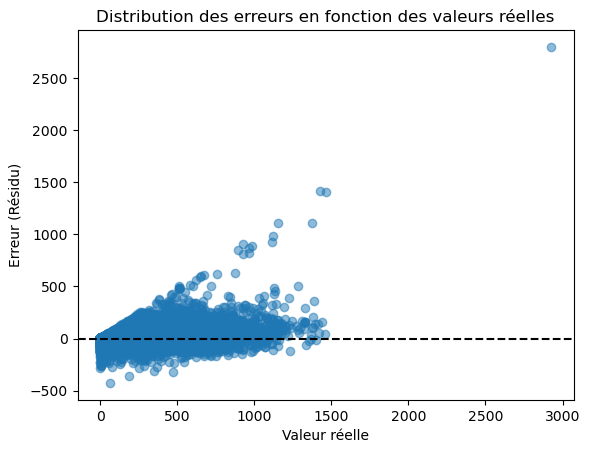

In [18]:
# Calcul des résidus
df_results["Résidu"] = df_results["Réel"] - df_results["Prédit"]

plt.scatter(df_results["Réel"], df_results["Résidu"], alpha=0.5)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Valeur réelle")
plt.ylabel("Erreur (Résidu)")
plt.title("Distribution des erreurs en fonction des valeurs réelles")
plt.show()

In [14]:
# Calcul de l'importance des caractéristiques

n_repeats = 5  
sample_size = 1000  

X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.sample(n=sample_size, random_state=42)


result = permutation_importance(model, X_test_sample, y_test_sample, n_repeats=n_repeats, random_state=42, n_jobs=-1)

# Création d'un DataFrame pour afficher les importances
df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

# Tri par importance
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

# Affichage des résultats
print(df_feature_importance)


                                               Feature  Importance
3                                                Heure    1.126973
1                                                 Mois    0.193203
4                                         Jour_semaine    0.145402
2                                                Année    0.134380
10   Nom du compteur_106 avenue Denfert Rochereau N...    0.077535
105           Nom du compteur_Totem Cours la Reine O-E    0.059925
101  Nom du compteur_Totem 73 boulevard de Sébastop...    0.040680
9       Nom du compteur_102 boulevard de Magenta SE-NO    0.034384
61              Nom du compteur_90 Rue De Sèvres NE-SO    0.033111
0                                                 Jour    0.029766
62              Nom du compteur_90 Rue De Sèvres SO-NE    0.027546
99          Nom du compteur_Totem 64 Rue de Rivoli O-E    0.023509
6                                   Vacances scolaires    0.022959
80   Nom du compteur_Face au 8 avenue de la porte d...    0.02

In [15]:
df_sorted = df_feature_importance.sort_values(by = "Importance", ascending = False)

In [16]:
df_top_10 = df_sorted.head(20)

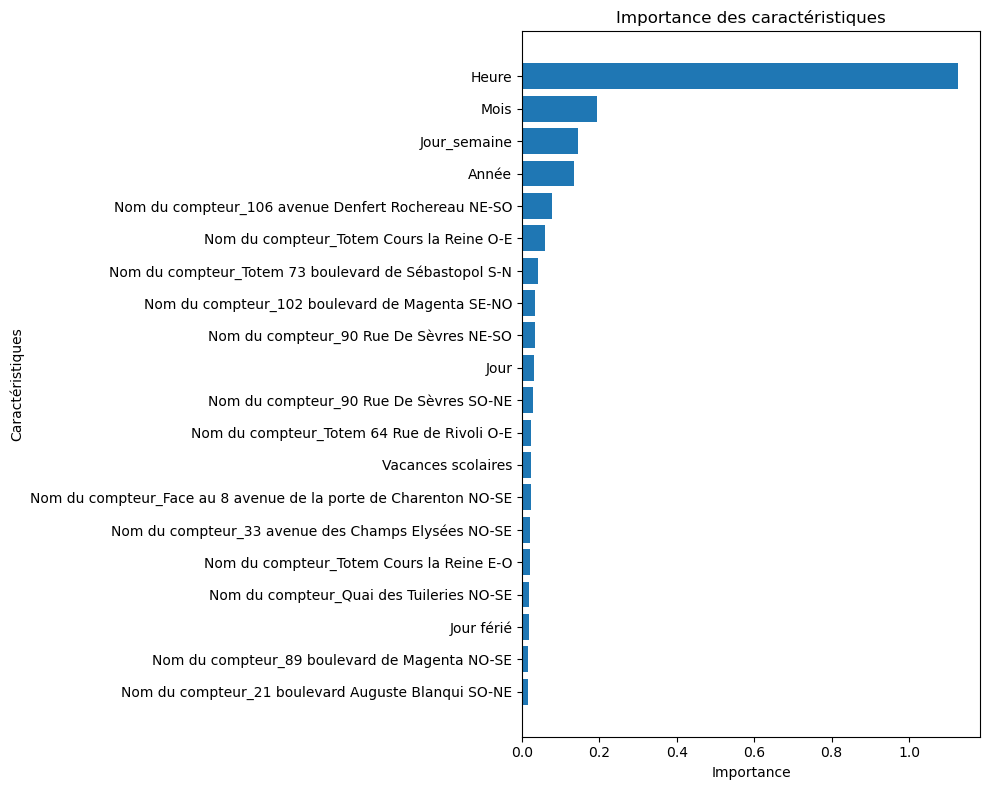

In [17]:
# Tracer les importances des caractéristiques par ordre d'importance

plt.figure(figsize=(10, 8))
plt.barh(df_top_10["Feature"], df_top_10["Importance"])
plt.xlabel("Importance")
plt.ylabel("Caractéristiques")
plt.title("Importance des caractéristiques")
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher la plus importante en haut
plt.tight_layout()
plt.show()